# MemN으로 질의 응답(Question Answering) 구현

In [1]:
# ! pip install customized_konlpy

In [2]:
from ckonlpy.tag import Twitter
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
from nltk import FreqDist
from functools import reduce
import os
import re
import matplotlib.pyplot as plt

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

### 데이터 가져오기

In [4]:
# 한국어 bAbi 데이터셋
# 훈련 데이터 : https://bit.ly/31SqtHy
# 테스트 데이터 : https://bit.ly/3f7rH5g

# 영어 bAbi(pronounced “baby") 데이터셋
# from tensorflow.keras.utils import get_file
# import tarfile

# path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/'
#                 'babi_tasks_1-20_v1-2.tar.gz')
# with tarfile.open(path) as tar:
#     tar.extractall()
#     tar.close()

In [5]:
TRAIN_FILE = os.path.join("qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join("qa1_single-supporting-fact_test_kor.txt")

In [6]:
# TRAIN_FILE = os.path.join("/content/drive/My Drive/NLP_LAB/qa1_single-supporting-fact_train_kor.txt")
# TEST_FILE = os.path.join("/content/drive/My Drive/NLP_LAB/qa1_single-supporting-fact_test_kor.txt")

In [7]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    i = i + 1
    print(line)
    if i == 20:
        break        

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


In [8]:
# 숫자 1부터 15까지 한 개의 스토리이고 그 중간 중간에 질문  
# 3번, 6번, 9번, 12번, 15번 라인이 각 스토리 중간에 이어지는 질문, 질문 옆에 정답(정답의 라인번호_)
# 숫자 1이 다시 나오면 이제부터는 다시 별개의 스토리가 시작됨

### 데이터 전처리

In [9]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []

        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [10]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [11]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)
# train_stories, train_questions, train_answers

In [12]:
print('훈련용 스토리의 개수 :', len(train_stories))
print('훈련용 질문의 개수 :',len(train_questions))
print('훈련용 답변의 개수 :',len(train_answers))
print('테스트용 스토리의 개수 :',len(test_stories))
print('테스트용 질문의 개수 :',len(test_questions))
print('테스트용 답변의 개수 :',len(test_answers))

훈련용 스토리의 개수 : 10000
훈련용 질문의 개수 : 10000
훈련용 답변의 개수 : 10000
테스트용 스토리의 개수 : 1000
테스트용 질문의 개수 : 1000
테스트용 답변의 개수 : 1000


In [13]:
train_stories[3572]  # 질문1개 마다 누적 저장되어 있음

['은경이는 부엌으로 가버렸습니다.',
 '필웅이는 사무실로 가버렸습니다.',
 '수종이는 복도로 뛰어갔습니다.',
 '은경이는 사무실로 복귀했습니다.',
 '경임이는 사무실로 이동했습니다.',
 '경임이는 침실로 갔습니다.']

In [14]:
train_questions[3572]

'은경이는 어디야? '

In [15]:
train_answers[3572]

'사무실'

In [16]:
# Twitter(Okt) 테스트
twitter = Twitter()
print(twitter.morphs('은경이는 화장실로 이동했습니다.'))
print(twitter.morphs('경임이는 정원으로 가버렸습니다.'))
print(twitter.morphs('수종이는 복도로 뛰어갔습니다.'))
print(twitter.morphs('필웅이는 부엌으로 복귀했습니다.'))
print(twitter.morphs('수종이는 사무실로 갔습니다.'))
print(twitter.morphs('은경이는 침실로 갔습니다.'))

C:\ProgramData\Anaconda3\envs\tf20\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['은', '경이', '는', '화장실', '로', '이동', '했습니다', '.']
['경', '임', '이', '는', '정원', '으로', '가버렸습니다', '.']
['수종', '이', '는', '복도', '로', '뛰어갔습니다', '.']
['필웅이', '는', '부엌', '으로', '복귀', '했습니다', '.']
['수종', '이', '는', '사무실', '로', '갔습니다', '.']
['은', '경이', '는', '침실', '로', '갔습니다', '.']


In [17]:
twitter.add_dictionary('은경이', 'Noun')
twitter.add_dictionary('경임이', 'Noun')
twitter.add_dictionary('수종이', 'Noun')

In [18]:
print(twitter.morphs('은경이는 화장실로 이동했습니다.'))
print(twitter.morphs('경임이는 정원으로 가버렸습니다.'))
print(twitter.morphs('수종이는 복도로 뛰어갔습니다.'))
print(twitter.morphs('필웅이는 부엌으로 복귀했습니다.'))
print(twitter.morphs('수종이는 사무실로 갔습니다.'))
print(twitter.morphs('은경이는 침실로 갔습니다.'))
# 사전 추가 후에는 이름이 제대로 분리된다

['은경이', '는', '화장실', '로', '이동', '했습니다', '.']
['경임이', '는', '정원', '으로', '가버렸습니다', '.']
['수종이', '는', '복도', '로', '뛰어갔습니다', '.']
['필웅이', '는', '부엌', '으로', '복귀', '했습니다', '.']
['수종이', '는', '사무실', '로', '갔습니다', '.']
['은경이', '는', '침실', '로', '갔습니다', '.']


### 토큰화

In [19]:
def tokenize(sent):
    return twitter.morphs(sent)

In [20]:
def preprocess_data(train_data, test_data):
    
    counter = FreqDist() # 문서에 사용된 단어(토큰)의 사용빈도 정보를 담는 클래스
                         # 단어를 키(key), 출현빈도를 값(value)으로 가지는 사전 자료형과 유사
        
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []

    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories))     # 각 story의 길이 저장
            for word in stories:               # 단어 집합에 단어 추가
                counter[word] += 1             # 단어의 출현 빈도를 1 증가
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어 집합 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
                                                     # most_common(): 가장 출현 횟수가 높은 단어와 빈도를 반환
    idx2word = {idx : word for word, idx in word2idx.items()} # key와 value를 서로 바꿈

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [21]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data) # 시간 소요 

In [22]:
print(word2idx)

{'는': 1, '.': 2, '로': 3, '했습니다': 4, '으로': 5, '경임이': 6, '은경이': 7, '수종이': 8, '필웅이': 9, '이동': 10, '가버렸습니다': 11, '뛰어갔습니다': 12, '복귀': 13, '화장실': 14, '정원': 15, '복도': 16, '갔습니다': 17, '사무실': 18, '부엌': 19, '침실': 20, '어디': 21, '야': 22, '?': 23}


In [23]:
vocab_size = len(word2idx) + 1
print(vocab_size)

24


In [24]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 70
질문의 최대 길이 : 5


### 벡터화

In [25]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

        # 스토리와 질문은 각각의 최대 길이로 패딩
        # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [26]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [27]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)
Xstrain[:3], Xqtrain[:3], Ytrain[:3]

(10000, 70) (10000, 5) (10000, 24) (1000, 70) (1000, 5) (1000, 24)


(array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  1, 14,  3, 17,  2,  7,
          1, 16,  3, 10,  4,  2],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  1, 14,  3,
         17,  2,  7,  1, 16,  3, 10,  4,  2,  8,  1, 16,  3, 13,  4,  2,
          6,  1, 15,  5, 17,  2],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          9,  1, 14,  3, 17,  2,  7,  1, 16,  3, 10,  4,  2,  8,  1, 16,
          3, 13,  4,  2,  6,  1, 15,  5, 17,  2,  7,  1, 18,  3, 17,  2,
          6,  1, 14,  3, 12,  2]]),
 array([[ 9,  1, 21,

### 학습 모델 구현

In [28]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation

In [29]:
train_epochs = 120   # 에포크 횟수
batch_size = 32      # 배치 크기
embed_size = 50      # 임베딩 크기
lstm_size = 64       # LSTM의 크기
dropout_rate = 0.30  # 과적합 방지 기법인 드롭아웃 적용 비율

In [30]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))

print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_1:0", shape=(None, 70), dtype=float32)
Question: Tensor("input_2:0", shape=(None, 5), dtype=float32)


In [31]:
# 스토리를 위한 첫번째 임베딩. 그림에서 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embedding_dim) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
input_encoder_m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          1200      
_________________________________________________________________
dropout (Dropout)            (None, None, 50)          0         
Total params: 1,200
Trainable params: 1,200
Non-trainable params: 0
_________________________________________________________________


In [32]:
# 스토리를 위한 두번째 임베딩. 그림에서 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)
input_encoder_c.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 5)           120       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 5)           0         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [33]:
# 질문을 위한 임베딩. 그림에서 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embedding_dim) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원
question_encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 5, 50)             1200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 50)             0         
Total params: 1,200
Trainable params: 1,200
Non-trainable params: 0
_________________________________________________________________


In [34]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m Tensor("sequential/Identity:0", shape=(None, 70, 50), dtype=float32)
Input encoded c Tensor("sequential_1/Identity:0", shape=(None, 70, 5), dtype=float32)
Question encoded Tensor("sequential_2/Identity:0", shape=(None, 5, 50), dtype=float32)


In [35]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.  어텐션 메커니즘의 의도를 갖고 있다
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)  # 
print('Match shape', match)
# 결과 : (samples, story_maxlen, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_max_len, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_max_len)
print('Response shape', response)

# Permute((2, 1)) : 입력 데이터의 차원의 값을  바꿈, (N,70,5) --> (N,5,70)
# tf.keras.layers.Permute( dims, **kwargs )  # Permutes the dimensions of the input according to a given pattern.
# Permutation pattern does not include the samples dimension. Indexing starts at 1.
# For instance, (2, 1) permutes the first and second dimensions of the input.

# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)

answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Match shape Tensor("activation/Identity:0", shape=(None, 70, 5), dtype=float32)
Response shape Tensor("permute/Identity:0", shape=(None, 5, 70), dtype=float32)
Answer shape Tensor("concatenate/Identity:0", shape=(None, 5, 120), dtype=float32)


In [36]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         multiple             1200        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 5, 50)        1200        input_2[0][0]                    
______________________________________________________________________________________________

In [37]:
# start training the model, 약 4분 소요(CPU)
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))

# save model
model.save('model.h5') # 모델의 구조, 가중치, 훈련 설정을 하나의 파일에 저장

Train on 10000 samples, validate on 1000 samples
Epoch 1/120
10000/10000 [==============================] - 5s 474us/sample - loss: 1.8778 - acc: 0.1776 - val_loss: 1.7605 - val_acc: 0.2020
Epoch 2/120
10000/10000 [==============================] - 2s 172us/sample - loss: 1.6648 - acc: 0.2912 - val_loss: 1.5772 - val_acc: 0.3710
Epoch 3/120
10000/10000 [==============================] - 2s 167us/sample - loss: 1.5471 - acc: 0.3861 - val_loss: 1.4924 - val_acc: 0.4180
Epoch 4/120
10000/10000 [==============================] - 2s 171us/sample - loss: 1.4695 - acc: 0.4303 - val_loss: 1.4197 - val_acc: 0.4720
Epoch 5/120
10000/10000 [==============================] - 2s 170us/sample - loss: 1.4363 - acc: 0.4570 - val_loss: 1.3855 - val_acc: 0.4720
Epoch 6/120
10000/10000 [==============================] - 2s 175us/sample - loss: 1.3778 - acc: 0.4764 - val_loss: 1.3247 - val_acc: 0.5090
Epoch 7/120
10000/10000 [==============================] - 2s 176us/sample - loss: 1.3305 - acc: 0.4973 -

10000/10000 [==============================] - 2s 231us/sample - loss: 0.0241 - acc: 0.9928 - val_loss: 0.2970 - val_acc: 0.9470
Epoch 116/120
10000/10000 [==============================] - 2s 225us/sample - loss: 0.0249 - acc: 0.9935 - val_loss: 0.2737 - val_acc: 0.9460
Epoch 117/120
10000/10000 [==============================] - 2s 235us/sample - loss: 0.0253 - acc: 0.9912 - val_loss: 0.2992 - val_acc: 0.9420
Epoch 118/120
10000/10000 [==============================] - 2s 234us/sample - loss: 0.0292 - acc: 0.9923 - val_loss: 0.2891 - val_acc: 0.9400
Epoch 119/120
10000/10000 [==============================] - 2s 229us/sample - loss: 0.0349 - acc: 0.9905 - val_loss: 0.2698 - val_acc: 0.9440
Epoch 120/120
10000/10000 [==============================] - 2s 228us/sample - loss: 0.0262 - acc: 0.9934 - val_loss: 0.3009 - val_acc: 0.9410


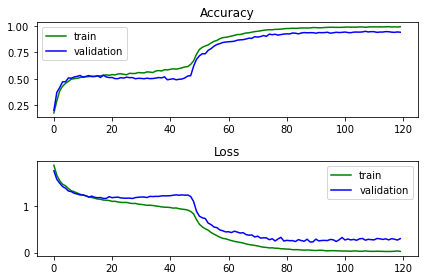

In [38]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [39]:
# import tensorflow as tf
# new_model = tf.keras.models.load_model('model.h5') # 저장된 모델로부터 새로운 케라스 모델을 로드
# new_model.summary() # 저장했던 모델과 동일

In [40]:
NUM_DISPLAY = 30

print("{:18}|{:5}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:7} {}".format(question, label, prediction))

질문                |실제값  |예측값
---------------------------------------
은경이 는 어디 야 ?        : 복도      복도
필웅이 는 어디 야 ?        : 화장실     화장실
경임이 는 어디 야 ?        : 부엌      부엌
경임이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 부엌      부엌
경임이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 정원      정원
수종이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 사무실     사무실
수종이 는 어디 야 ?        : 사무실     복도
필웅이 는 어디 야 ?        : 부엌      부엌
필웅이 는 어디 야 ?        : 정원      정원
수종이 는 어디 야 ?        : 사무실     사무실
필웅이 는 어디 야 ?        : 침실      침실
필웅이 는 어디 야 ?        : 침실      침실
은경이 는 어디 야 ?        : 부엌      부엌
은경이 는 어디 야 ?        : 정원      정원
은경이 는 어디 야 ?        : 부엌      부엌
수종이 는 어디 야 ?        : 사무실     부엌
은경이 는 어디 야 ?        : 부엌      정원
필웅이 는 어디 야 ?        : 복도      복도
은경이 는 어디 야 ?        : 사무실     사무실
은경이 는 어디 야 ?        : 사무실     사무실
경임이 는 어디 야 ?        : 복도      복도
수종이 는 어디 야 ?        : 침실      침실
경임이 는 어디 야 ?        : 침실      침실
필웅이 는 어디 야 ?        : 침실      침실
수종이 는 어디 야 ?        : 부엌      부엌
수종